#설명
이번 과제의 목표는 Faster R-CNN이 실제로 어떠한 구조로 돌아가는지 살펴보고 이해하기 위함입니다. <br> 그 속에서 Object Detection이 이런것이구나를 느끼셨으면 좋겠습니다. <br>

중간중간에 빈칸을 뚫어넣어 흐름을 따라갈 수 있게끔 만들었고, 나머지 부분은 큰 부담안가지시고 한번 쭉 돌려보시면 좋을 것 같습니다!

# Faster R-CNN Implementations by Pytorch

**Reference** : [How FasterRCNN works and step-by-step PyTorch implementation](https://youtu.be/4yOcsWg-7g8)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Dependencies

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image

In [2]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print(DEVICE, torch.cuda.get_device_name(0))
else:
    DEVICE = torch.device("cpu")
    print(DEVICE)

cuda Tesla T4


## Data Preprocessing

### 1) Visualize image and bounding boxes

(960, 1440, 3)


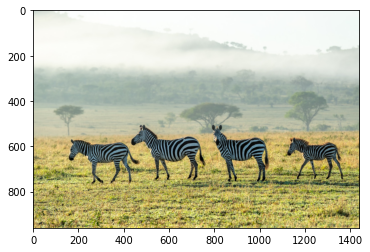

In [3]:
# In this example, only use 1 image, i.e, batch_size=1
# input image could be of any size

#####################################################
#제가 드린 zebra 이미지를 각자 컴퓨터 경로에 맞게 읽어오시면 됩니다
#####################################################

img0 = cv2.imread("zebra.jpg") # colab에 파일 올려서 사용

img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
print(img0.shape)
plt.imshow(img0)
plt.show()

In [4]:
# object information : a set of bounding boxes [x1, y1, x2, y2] 
# and their labels 

## Ground Truth ##
bbox0 = np.array([[223, 782, 623, 1074], [597, 695, 1038, 1050], 
                  [1088, 699, 1452, 1057], [1544, 771, 1914, 1063]]) 
labels = np.array([1, 1, 1, 1]) # 0: background, 1: zebra

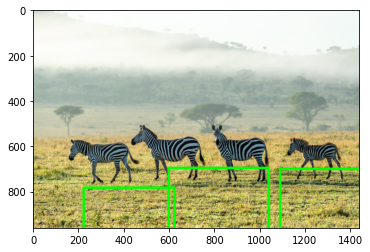

In [5]:
# display bounding box and labels

img0_clone = np.copy(img0)
for i in range(len(bbox0)):
    cv2.rectangle(img0_clone, (bbox0[i][0], bbox0[i][1]), 
                              (bbox0[i][2], bbox0[i][3]),
                 color=(0, 255, 0), thickness=10)
plt.imshow(img0_clone)
plt.show()

### 2) Resize image and bounding boxes

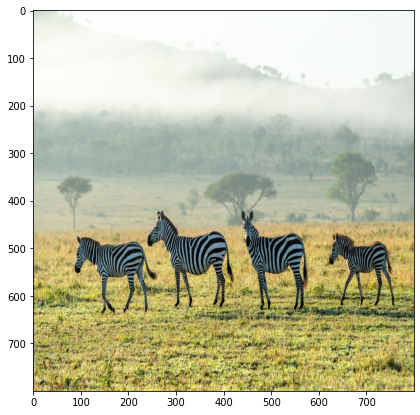

In [6]:
# resize the input images to h=800, w=800


## 편의를 위해 원본 resize ##
img = cv2.resize(img0, dsize=(800, 800), interpolation=cv2.INTER_CUBIC)
plt.figure(figsize=(7, 7))
plt.imshow(img)
# plt.grid(True, color="black")
plt.show()

0.5555555555555556 0.8333333333333334
[[ 123  651  346  895]
 [ 331  579  576  875]
 [ 604  582  806  880]
 [ 857  642 1063  885]]


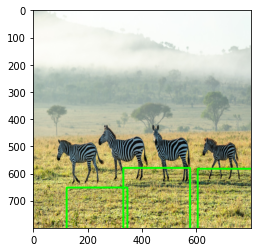

In [7]:
# change the bounding box coordinates
# original image size : (1333, 2000)


## Resize한 이미지에 맞게 Ground Truth도 위치 변경 ##

Wratio = 800/img0.shape[1]
Hratio = 800/img0.shape[0]

print(Wratio, Hratio)

ratioList = [Wratio, Hratio, Wratio, Hratio]
bbox = []

for box in bbox0:
    box = [int(a*b) for a, b in zip(box, ratioList)]
    bbox.append(box)
    
bbox = np.array(bbox)
print(bbox)

img_clone = np.copy(img)
for i in range(len(bbox)):
    cv2.rectangle(img_clone, (bbox[i][0], bbox[i][1]), (bbox[i][2], bbox[i][3]), color=(0, 255, 0), thickness=5)
plt.imshow(img_clone)
plt.show()

## Define Feature extractor

### 1) Load pretrained VGG16

In [8]:
# only print feature extraction part of VGG16

model = torchvision.models.vgg16(pretrained=True).to(DEVICE)
features = list(model.features)
print(len(features))
print(features)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


31
[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1

### 2) Only collect required layers

### 과제 1. Sub sampling ratio에 맞게 feature map을 출력하는 layer 찾기

In [9]:
# only collect layers with output feature map size (W, H) < 50

#####################################################
# Sub sampling ratio를 1/16이라 할때, 50*50 크기가 되는 layer까지만 feature extractor로 사용하려 합니다. (원본 800*800)
# 아래의 #####에 적절한 코드를 넣어주시면 됩니다 
#####################################################

dummy_img = torch.zeros((1, 3, 800, 800)).float() # test image array
print(dummy_img.shape)

req_features = []
output = dummy_img.clone().to(DEVICE)

for feature in features:
    output = feature(output)
    print(output.size())
    # 힌트: print(output.size())를 해보세요! -> 각각의 값들이 의미하는 바가 무엇일까요? CNN에 들어가는 tensor의 형태를 생각해보시면 됩니다. 
    if output.size()[2] < 50:
      break
    req_features.append(feature)
    out_channels = output.size()[3]
    
print(len(req_features))
print(req_features)
print(out_channels)


torch.Size([1, 3, 800, 800])
torch.Size([1, 64, 800, 800])
torch.Size([1, 64, 800, 800])
torch.Size([1, 64, 800, 800])
torch.Size([1, 64, 800, 800])
torch.Size([1, 64, 400, 400])
torch.Size([1, 128, 400, 400])
torch.Size([1, 128, 400, 400])
torch.Size([1, 128, 400, 400])
torch.Size([1, 128, 400, 400])
torch.Size([1, 128, 200, 200])
torch.Size([1, 256, 200, 200])
torch.Size([1, 256, 200, 200])
torch.Size([1, 256, 200, 200])
torch.Size([1, 256, 200, 200])
torch.Size([1, 256, 200, 200])
torch.Size([1, 256, 200, 200])
torch.Size([1, 256, 100, 100])
torch.Size([1, 512, 100, 100])
torch.Size([1, 512, 100, 100])
torch.Size([1, 512, 100, 100])
torch.Size([1, 512, 100, 100])
torch.Size([1, 512, 100, 100])
torch.Size([1, 512, 100, 100])
torch.Size([1, 512, 50, 50])
torch.Size([1, 512, 50, 50])
torch.Size([1, 512, 50, 50])
torch.Size([1, 512, 50, 50])
torch.Size([1, 512, 50, 50])
torch.Size([1, 512, 50, 50])
torch.Size([1, 512, 50, 50])
torch.Size([1, 512, 25, 25])
30
[Conv2d(3, 64, kernel_size=(

In [10]:
# convert this list into a Seqeuntial module

faster_rcnn_feature_extractor = nn.Sequential(*req_features)

In [11]:
# test the results of the input image pass through the feature extractor

transform = transforms.Compose([transforms.ToTensor()])
imgTensor = transform(img).to(DEVICE)
imgTensor = imgTensor.unsqueeze(0)
output_map = faster_rcnn_feature_extractor(imgTensor)

print(output_map.size())

torch.Size([1, 512, 50, 50])


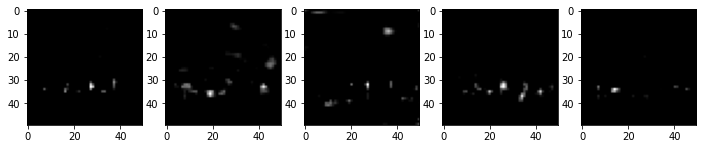

In [12]:
# visualize the first 5 channels of the 50*50*512 feature maps

imgArray = output_map.data.cpu().numpy().squeeze(0)
fig = plt.figure(figsize=(12, 4))
figNo = 1

for i in range(5):
    fig.add_subplot(1, 5, figNo)
    plt.imshow(imgArray[i], cmap='gray')
    figNo += 1
    
plt.show()

## Generate Anchors Boxes

### 1) Generate Anchors

In [13]:
# sub-sampling rate = 1/16
# image size : 800x800
# sub-sampled feature map size : 800 x 1/16 = 50
# 50 x 50 = 2500 anchors and each anchor generate 9 anchor boxes
# total anchor boxes = 50 x 50 x 9 = 22500
# x,y intervals to generate anchor box center

feature_size = 800 // 16
ctr_x = np.arange(16, (feature_size + 1) * 16, 16)
ctr_y = np.arange(16, (feature_size + 1) * 16, 16)
print(len(ctr_x))
print(ctr_x)

50
[ 16  32  48  64  80  96 112 128 144 160 176 192 208 224 240 256 272 288
 304 320 336 352 368 384 400 416 432 448 464 480 496 512 528 544 560 576
 592 608 624 640 656 672 688 704 720 736 752 768 784 800]


In [14]:
# anchor box를 생성하기 위한 2500개(50*50)의 중심좌표 찾기

index = 0
ctr = np.zeros((2500, 2))

for i in range(len(ctr_x)):
    for j in range(len(ctr_y)):
        ctr[index, 1] = ctr_x[i] - 8 #한개의 grid cell의 크기 16
        ctr[index, 0] = ctr_y[j] - 8
        index += 1

# ctr => [[center x, center y], ...]
print(ctr.shape)
print(ctr[:10, :])

(2500, 2)
[[  8.   8.]
 [ 24.   8.]
 [ 40.   8.]
 [ 56.   8.]
 [ 72.   8.]
 [ 88.   8.]
 [104.   8.]
 [120.   8.]
 [136.   8.]
 [152.   8.]]


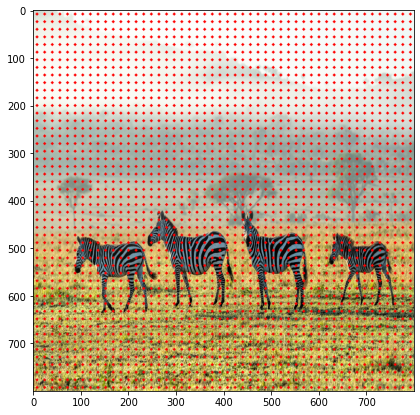

In [15]:
# display the 2500 anchors within image

img_clone2 = np.copy(img)
ctr_int = ctr.astype("int32")

plt.figure(figsize=(7, 7))
for i in range(ctr.shape[0]):
    cv2.circle(img_clone2, (ctr_int[i][0], ctr_int[i][1]),
              radius=1, color=(255, 0, 0), thickness=3)
plt.imshow(img_clone2)
plt.show()

### 2) Generate Anchor boxes

In [16]:
# 각 anchor당 9개의 anchor boxes 생성
# 2500 x 9 = 22500 anchor boxes

ratios = [0.5, 1, 2]
scales = [8, 16, 32]
sub_sample = 16

anchor_boxes = np.zeros(((feature_size * feature_size * 9), 4))
index = 0

for c in ctr:                        # per anchors
    ctr_y, ctr_x = c
    for i in range(len(ratios)):     # per ratios
        for j in range(len(scales)): # per scales
            
            # anchor box height, width
            h = sub_sample * scales[j] * np.sqrt(ratios[i])
            w = sub_sample * scales[j] * np.sqrt(1./ ratios[i])
            
            # anchor box [x1, y1, x2, y2] <- x1,y1 : 좌상단 / x2,y2 : 우하단 
            anchor_boxes[index, 1] = ctr_y - h / 2.
            anchor_boxes[index, 0] = ctr_x - w / 2.
            anchor_boxes[index, 3] = ctr_y + h / 2.
            anchor_boxes[index, 2] = ctr_x + w / 2.
            index += 1
            
print(anchor_boxes.shape)
print(anchor_boxes[:10, :])

(22500, 4)
[[ -82.50966799  -37.254834     98.50966799   53.254834  ]
 [-173.01933598  -82.50966799  189.01933598   98.50966799]
 [-354.03867197 -173.01933598  370.03867197  189.01933598]
 [ -56.          -56.           72.           72.        ]
 [-120.         -120.          136.          136.        ]
 [-248.         -248.          264.          264.        ]
 [ -37.254834    -82.50966799   53.254834     98.50966799]
 [ -82.50966799 -173.01933598   98.50966799  189.01933598]
 [-173.01933598 -354.03867197  189.01933598  370.03867197]
 [ -82.50966799  -21.254834     98.50966799   69.254834  ]]


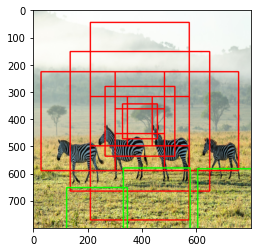

In [17]:
# display the anchor boxes of one anchor and the ground truth boxes

img_clone = np.copy(img)

# draw random anchor boxes
for i in range(11025, 11034):
    x1 = int(anchor_boxes[i][0])
    y1 = int(anchor_boxes[i][1])
    x2 = int(anchor_boxes[i][2])
    y2 = int(anchor_boxes[i][3])
    
    cv2.rectangle(img_clone, (x1, y1), (x2, y2), color=(255, 0, 0),
                 thickness=3)

# draw ground truth boxes
for i in range(len(bbox)):
    cv2.rectangle(img_clone, (bbox[i][0], bbox[i][1]), 
                             (bbox[i][2], bbox[i][3]),
                 color=(0, 255, 0), thickness=3)

plt.imshow(img_clone)
plt.show()

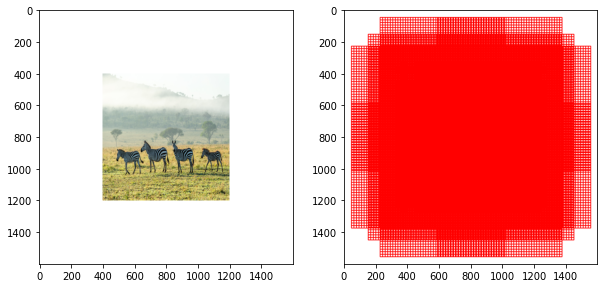

In [18]:
# draw all anchor boxes

# add paddings(can't draw anchor boxes out of image boundary) <- 이미지 밖으로 나가는 anchor box 분명히 생김 
img_clone3 = np.copy(img)
img_clone4 = cv2.copyMakeBorder(img_clone3,400,400,400,400,cv2.BORDER_CONSTANT, value=(255, 255, 255))
img_clone5 = np.copy(img_clone4)

for i in range(len(anchor_boxes)):
    x1 = int(anchor_boxes[i][0])
    y1 = int(anchor_boxes[i][1])
    x2 = int(anchor_boxes[i][2])
    y2 = int(anchor_boxes[i][3])
    
    cv2.rectangle(img_clone5, (x1+400, y1+400), (x2+400, y2+400), color=(255, 0, 0),
                 thickness=3)

plt.figure(figsize=(10, 10))
plt.subplot(121), plt.imshow(img_clone4)
plt.subplot(122), plt.imshow(img_clone5)
plt.show()

## Target Anchors

### 1) Only choose anchor boxes inside the image

In [19]:
# 이미지 경계 밖으로 나가는 anchor boxes 모두 제거 
# valid anchor boxes with (x1, y1) > 0 and (x2, y2) <= 800

index_inside = np.where(
        (anchor_boxes[:, 0] >= 0) &
        (anchor_boxes[:, 1] >= 0) &
        (anchor_boxes[:, 2] <= 800) &
        (anchor_boxes[:, 3] <= 800))[0]

print(index_inside.shape)

# only 8940 anchor boxes are inside the boundary out of 22500
valid_anchor_boxes = anchor_boxes[index_inside]
print(valid_anchor_boxes.shape)

(8940,)
(8940, 4)


### 2) Calculate IoUs

In [20]:
# 8940개의 anchor boxes와 4개의 Ground truth objects, 이들간의 IoU를 계산해보자 

# since we have 8940 anchor boxes and 4 ground truth objects,
# we should get an array with (8940, 4) as the output
# [IoU with gt box1, IoU with gt box2, IoU with gt box3,IoU with gt box4]

ious = np.empty((len(valid_anchor_boxes),4), dtype=np.float32)
ious.fill(0)

# anchor boxes
for i, anchor_box in enumerate(valid_anchor_boxes):
    xa1, ya1, xa2, ya2 = anchor_box
    anchor_area = (xa2 - xa1) * (ya2 - ya1)
    
    # ground truth boxes
    for j, gt_box in enumerate(bbox):
        xb1, yb1, xb2, yb2 = gt_box
        box_area = (xb2 - xb1) * (yb2 - yb1)
        
        inter_x1 = max([xb1, xa1])
        inter_y1 = max([yb1, ya1])
        inter_x2 = min([xb2, xa2])
        inter_y2 = min([yb2, ya2])
        
        if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
            inter_area = (inter_x2 - inter_x1) * (inter_y2 - inter_y1)
            iou = inter_area / (anchor_area + box_area - inter_area)
        else:
            iou = 0
        
        ious[i, j] = iou
        
print(ious.shape)
print(ious[8930:8940, :])

(8940, 4)
[[0.         0.         0.07702471 0.        ]
 [0.         0.         0.09941643 0.        ]
 [0.         0.         0.12275898 0.        ]
 [0.         0.         0.14711425 0.        ]
 [0.         0.         0.17254958 0.        ]
 [0.         0.         0.19913846 0.        ]
 [0.         0.         0.2269612  0.        ]
 [0.         0.         0.2561057  0.        ]
 [0.         0.         0.27217755 0.        ]
 [0.         0.         0.27217755 0.        ]]


### 3) Sample positive/negative anchor boxes

In [21]:
# what anchor box has max Iou with the ground truth box
# 각 Ground Truth box와 Iou가 최대인 anchor box 찾기 (행방향 탐색)

gt_argmax_ious = ious.argmax(axis=0)
print(gt_argmax_ious)

gt_max_ious = ious[gt_argmax_ious, np.arange(ious.shape[1])]
print(gt_max_ious)

gt_argmax_ious = np.where(ious == gt_max_ious)[0]
print(gt_argmax_ious)

[1957 5495 8425    0]
[0.35526806 0.6077139  0.4577285  0.        ]
[   0    1    2 ... 8937 8938 8939]


In [22]:
# what ground truth bbox is associated with each anchor box
# 개별 G.T와 anchor box들간의 관계(열방향 탐색)

argmax_ious = ious.argmax(axis=1)
print(argmax_ious.shape)
print(argmax_ious)

max_ious = ious[np.arange(len(index_inside)), argmax_ious]
print(max_ious)

(8940,)
[0 0 0 ... 2 2 2]
[0.         0.         0.         ... 0.2561057  0.27217755 0.27217755]


In [23]:
# set the labels of 8940 valid anchor boxes to -1(ignore)

# anchor labeling(positive/negative) 이전 라벨 초기화 
label = np.empty((len(index_inside),), dtype=np.int32)
label.fill(-1)
print(label.shape)

(8940,)


In [24]:
# use IoU to assign 1 (objects) to two kind of anchors
# a) the anchors with the highest IoU overlap with a ground truth box <- G.T와의 IoU가 가장 높은 anchor
# b) an anchor that has an IoU overlap higher than 0.7 with ground truth box <- G.T와의 IoU가 0.7 이상인 anchor 
# >>> positive anchor 

# Assign 0 (background) to an anchor if its IoU ratio is lower than 0.3 <- G.T와의 IoU가 0.3 이하인 anchor 
# >> negative anchor 

pos_iou_threshold = 0.7
neg_iou_threshold = 0.3

label[gt_argmax_ious] = 1
label[max_ious >= pos_iou_threshold] = 1
label[max_ious < neg_iou_threshold] = 0

In [25]:
# Every time mini-batch training take only 256 valid anchor boxes to train RPN
# of which 128 positive examples, 128 negative-examples
# disable leftover positive/negative anchors 


#RPN을 훈련시킬때 256개의 mini batch를 사용하는데 비율을 최대한 맞춰서 간다 128/128(positive/negative)

n_sample = 256
pos_ratio = 0.5
n_pos = pos_ratio * n_sample

pos_index = np.where(label == 1)[0]

#남는 positive, negative sample들 label 변수에 -1로 저장 
#하지만 일반적으로 positive sample의 수가 128개 미만일 경우, 부족한만큼의 sample을 negative sample에서 추출함. 

if len(pos_index) > n_pos: 
    disable_index = np.random.choice(pos_index,
                                    size = int(len(pos_index) - n_pos),
                                    replace=False)
    label[disable_index] = -1
    
n_neg = n_sample * np.sum(label == 1)
neg_index = np.where(label == 0)[0]

if len(neg_index) > n_neg:
    disable_index = np.random.choice(neg_index, 
                                    size = (len(neg_index) - n_neg), 
                                    replace = False)
    label[disable_index] = -1

In [26]:
# convert the format of valid anchor boxes [x1, y1, x2, y2] <- anchor box의 Location

# For each valid anchor box, find the groundtruth object which has max_iou 
# 유효한 각 anchor box에 대해 최대 IoU를 가지는 groundtruth 찾는다!

max_iou_bbox = bbox[argmax_ious]
print(max_iou_bbox.shape)

height = valid_anchor_boxes[:, 3] - valid_anchor_boxes[:, 1]
width = valid_anchor_boxes[:, 2] = valid_anchor_boxes[:, 0]
ctr_y = valid_anchor_boxes[:, 1] + 0.5 * height
ctr_x = valid_anchor_boxes[:, 0] + 0.5 * width

base_height = max_iou_bbox[:, 3] - max_iou_bbox[:, 1]
base_width = max_iou_bbox[:, 2] - max_iou_bbox[:, 0]
base_ctr_y = max_iou_bbox[:, 1] + 0.5 * base_height
base_ctr_x = max_iou_bbox[:, 0] + 0.5 * base_width

eps = np.finfo(height.dtype).eps
height = np.maximum(height, eps)
width = np.maximum(width, eps)

dy = (base_ctr_y - ctr_y) / height
dx = (base_ctr_x - ctr_x) / width
dh = np.log(base_height / height)
dw = np.log(base_width / width)

anchor_locs = np.vstack((dx, dy, dw, dh)).transpose()
print(anchor_locs.shape)

(8940, 4)
(8940, 4)


In [27]:
# First set the label=-1 and locations=0 of the 22500 anchor boxes, (라벨 및 위치 초기화)
# and then fill in the locations and labels of the 8940 valid anchor boxes (유효한 박스들 location 및 label 채워넣기 )
# NOTICE: For each training epoch, we randomly select 128 positive + 128 negative 
# from 8940 valid anchor boxes, and the others are marked with -1 (유효하지 않은 anchor box)

anchor_labels = np.empty((len(anchor_boxes),), dtype=label.dtype)
anchor_labels.fill(-1)
anchor_labels[index_inside] = label
print(anchor_labels.shape)
print(anchor_labels[:10])

anchor_locations = np.empty((len(anchor_boxes),) + anchor_boxes.shape[1:], dtype=anchor_locs.dtype)
anchor_locations.fill(0)
anchor_locations[index_inside, :] = anchor_locs
print(anchor_locations.shape)
print(anchor_locations[:10, :])

(22500,)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
(22500, 4)
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


## RPN(Region Proposal Network)

### 1) Define RPN

### 과제 2. reg_layer, cls_layer 맞추기 

In [28]:
# Send the features of the input image to the Region Proposal Network (RPN), 
# predict 22500 region proposals (ROIs)

#####################################################
# RPN 네트워크를 구성하는 문제입니다. 1*1 conv를 할때 output channel이 어떻게 되는지 맞춰보세요!
# 아래의 #####에 적절한 코드를 넣어주시면 됩니다 
#####################################################

in_channels = 512
mid_channels = 512
n_anchor = 9

conv1 = nn.Conv2d(in_channels, mid_channels, 3, 1, 1).to(DEVICE)
conv1.weight.data.normal_(0, 0.01)
conv1.bias.data.zero_()

# bounding box regressor
reg_layer = nn.Conv2d(mid_channels, 36, 1, 1, 0).to(DEVICE) # 9*4
reg_layer.weight.data.normal_(0, 0.01)
reg_layer.bias.data.zero_()

# classifier(object or not)
cls_layer = nn.Conv2d(mid_channels, 18, 1, 1, 0).to(DEVICE) #9*2 softmax
cls_layer.weight.data.normal_(0, 0.01)
cls_layer.bias.data.zero_()

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')

### 2) Classification and Bounding box regression

In [29]:
x = conv1(output_map.to(DEVICE)) # output_map = faster_rcnn_feature_extractor(imgTensor)
pred_anchor_locs = reg_layer(x) # bounding box regresor output
pred_cls_scores = cls_layer(x)  # classifier output 

print(pred_anchor_locs.shape, pred_cls_scores.shape)

torch.Size([1, 36, 50, 50]) torch.Size([1, 18, 50, 50])


In [30]:
# RPN의 tensor 형태를 anchor box에 맞게 변환 
# Position: [1, 36, 50, 50] => [1, 22500, 4] (dy, dx, dh, dw) 
# Classification: [1, 18, 50, 50] => [1, 22500, 2] (obj or no obj)

pred_anchor_locs = pred_anchor_locs.permute(0, 2, 3, 1).contiguous().view(1, -1, 4)
print(pred_anchor_locs.shape)

pred_cls_scores = pred_cls_scores.permute(0, 2, 3, 1).contiguous()
print(pred_cls_scores.shape)

objectness_score = pred_cls_scores.view(1, 50, 50, 9, 2)[:, :, :, :, 1].contiguous().view(1, -1)
print(objectness_score.shape)

pred_cls_scores = pred_cls_scores.view(1, -1, 2)
print(pred_cls_scores.shape)

torch.Size([1, 22500, 4])
torch.Size([1, 50, 50, 18])
torch.Size([1, 22500])
torch.Size([1, 22500, 2])


In [31]:
# According to the 22500 ROIs predicted by RPN and 22500 anchor boxes, 
# calculate the RPN loss¶

print(pred_anchor_locs.shape)
print(pred_cls_scores.shape)
print(anchor_locations.shape)
print(anchor_labels.shape)

torch.Size([1, 22500, 4])
torch.Size([1, 22500, 2])
(22500, 4)
(22500,)


In [32]:
rpn_loc = pred_anchor_locs[0]
rpn_score = pred_cls_scores[0]

gt_rpn_loc = torch.from_numpy(anchor_locations)
gt_rpn_score = torch.from_numpy(anchor_labels)

print(rpn_loc.shape, rpn_score.shape,
      gt_rpn_loc.shape, gt_rpn_score.shape)

torch.Size([22500, 4]) torch.Size([22500, 2]) torch.Size([22500, 4]) torch.Size([22500])


### 3) Multi-task loss

###  과제 3 : RPN loss 계산하기 

In [33]:
# For classification we use cross-entropy loss
rpn_cls_loss = F.cross_entropy(rpn_score.cpu(), gt_rpn_score.long().cpu(), ignore_index = -1)
print(rpn_cls_loss)

tensor(0.7024, grad_fn=<NllLossBackward0>)


In [34]:
# only positive samples
pos = gt_rpn_score > 0
mask = pos.unsqueeze(1).expand_as(rpn_loc)
print(mask.shape)

# take those bounding boxes whick have positive labels <- postivie sample에 대해서만 regression loss 계산 
mask_loc_preds = rpn_loc[mask].view(-1, 4)
mask_loc_targets = gt_rpn_loc[mask].view(-1, 4)
print(mask_loc_preds.shape, mask_loc_targets.shape)

#####################################################
## Regression Loss의 계산식을 물어보는 문제입니다.
## 강의자료의 smooth L1 계산식 참조 
## rpn_cls_loss와 rpn_reg_loss를 가지고 최종 loss를 계산해보세요 
#####################################################

x = torch.abs(mask_loc_targets.cpu() - mask_loc_preds.cpu()) #절댓값 씌워주기 
rpn_loc_loss = ((x < 1).float() * 0.5 * x ** 2) + ((x >= 1).float() * (x - 0.5))
print(rpn_loc_loss.sum())

torch.Size([22500, 4])
torch.Size([128, 4]) torch.Size([128, 4])
tensor(57.6114, dtype=torch.float64, grad_fn=<SumBackward0>)


In [35]:
rpn_lambda = 10
N_reg = (gt_rpn_score > 0).float().sum()
rpn_loc_loss = (rpn_lambda / N_reg) * rpn_loc_loss
rpn_loss = (1 / n_sample) * rpn_cls_loss + rpn_loc_loss
# print(rpn_loss)

## Proposal layer

### 1) Transform anchor boxes

In [36]:
# RPN에서 추출한 ROI들 Fast RCNN으로 보내기 ->  predict bbox + classifications

nms_thresh = 0.7  # non-maximum supression (NMS) 
n_train_pre_nms = 12000 # no. of train pre-NMS
n_train_post_nms = 2000 # after nms, training Fast R-CNN using 2000 RPN proposals
n_test_pre_nms = 6000
n_test_post_nms = 300 # During testing we evaluate 300 proposals,
min_size = 16

In [37]:
# the labelled 22500 anchor boxes
# format converted from [x1, y1, x2, y2] to [ctrx, ctry, w, h]

anc_height = anchor_boxes[:, 3] - anchor_boxes[:, 1]
anc_width = anchor_boxes[:, 2] - anchor_boxes[:, 0]
anc_ctr_y = anchor_boxes[:, 1] + 0.5 * anc_height
anc_ctr_x = anchor_boxes[:, 0] + 0.5 * anc_width
print(anc_ctr_x.shape)

(22500,)


In [38]:
# The 22500 anchor boxes location and labels predicted by RPN (convert to numpy)
# format = (dx, dy, dw, dh)

pred_anchor_locs_numpy = pred_anchor_locs[0].cpu().data.numpy()
objectness_score_numpy = objectness_score[0].cpu().data.numpy()

dy = pred_anchor_locs_numpy[:, 1::4]
dx = pred_anchor_locs_numpy[:, 0::4]
dh = pred_anchor_locs_numpy[:, 3::4]
dw = pred_anchor_locs_numpy[:, 2::4]
print(dy.shape)

(22500, 1)


In [39]:
# ctr_y = dy predicted by RPN * anchor_h + anchor_cy
# ctr_x similar
# h = exp(dh predicted by RPN) * anchor_h
# w similar

ctr_y = dy * anc_height[:, np.newaxis] + anc_ctr_y[:, np.newaxis]
ctr_x = dx * anc_width[:, np.newaxis] + anc_ctr_x[:, np.newaxis]
h = np.exp(dh) * anc_height[:, np.newaxis]
w = np.exp(dw) * anc_width[:, np.newaxis]
print(w.shape)

(22500, 1)


In [40]:
roi = np.zeros(pred_anchor_locs_numpy.shape, dtype=anchor_locs.dtype)
roi[:, 0::4] = ctr_x - 0.5 * w
roi[:, 1::4] = ctr_y - 0.5 * h
roi[:, 2::4] = ctr_x + 0.5 * w
roi[:, 3::4] = ctr_y + 0.5 * h

print(roi.shape)

(22500, 4)


### 2) Clip the anchor boxes to the image

In [41]:
# clip the predcited boxes to the image

img_size = (800, 800)
roi[:, slice(0, 4, 2)] = np.clip(roi[:, slice(0, 4, 2)], 0, img_size[0]) # [:, 0, 2]
roi[:, slice(1, 4, 2)] = np.clip(roi[:, slice(1, 4, 2)], 0, img_size[1]) # [:, 1, 3]

print(roi.shape, np.max(roi), np.min(roi))

(22500, 4) 800.0 0.0


In [42]:
# remove predicted boxes with either height or width < threshold
# 1차로 box 크기 기준치 미만 predicted box 삭제 

hs = roi[:, 3] - roi[:, 1]
ws = roi[:, 2] - roi[:, 0]

keep = np.where((hs >= min_size) & (ws >= min_size))[0]
roi = roi[keep, :]
score = objectness_score_numpy[keep]
print(keep.shape, roi.shape, score.shape)

(22500,) (22500, 4) (22500,)


### 3) Select top-12000 anchor boxes by objectness score

In [43]:
# sort all (proposal, score) pairs by score from highest to lowest
# objectness score를 바탕으로 anchor boxes 내림차순 정렬 (NMS전 필터링)

order = score.ravel().argsort()[::-1]
print(order.shape)

(22500,)


In [44]:
# take top pre_nms_topN (e.g. 12000 while training and 300 while testing)

order = order[:n_train_pre_nms]
roi = roi[order, :]
print(order.shape, roi.shape)

(12000,) (12000, 4)


### 4) Non maximum suppression(select 2000 bounding boxes)

In [45]:
# take all the roi boxes
x1 = roi[:, 0]
y1 = roi[:, 1]
x2 = roi[:, 2]
y2 = roi[:, 3]

# find the areas of all the boxes

areas = (x2 - x1 + 1) * (y2 - y1 + 1)

In [46]:
# take the indexes of order the probability score in descending order
# NMS 진행하여 bbox 2000개까지 축소

order = order.argsort()[::-1]
keep = []

while (order.size > 0):
  i = order[0] # take the 1st elt in roder and append to keep
  keep.append(i)

  xx1 = np.maximum(x1[i], x1[order[1:]])
  yy1 = np.maximum(y1[i], y1[order[1:]])
  xx2 = np.minimum(x2[i], x2[order[1:]])
  yy2 = np.minimum(y2[i], y2[order[1:]])

  w = np.maximum(0.0, xx2 - xx1 + 1)
  h = np.maximum(0.0, yy2 - yy1 + 1)

  inter = w * h
  ovr = inter / (areas[i] + areas[order[1:]] - inter)
  inds = np.where(ovr <= nms_thresh)[0]
  order = order[inds + 1]

keep = keep[:n_train_post_nms] # while training/testing, use accordingly
roi = roi[keep]
print(len(keep), roi.shape)

2000 (2000, 4)


## Proposal Target layer

### 1) Calculate IoUs

In [47]:
# RPN에서 구한 ROI 중 Fast RCNN training에 유용한 sample 다시 선택 

n_sample = 128 # number of samples from roi
pos_ratio = 0.25 # number of positive examples out of the n_samples
pos_iou_thresh = 0.5 # min iou of region proposal with any ground truth object to consider it as positive label
neg_iou_thresh_hi = 0.5 # iou 0~0.5 is considered as negative (0, background)
neg_iou_thresh_lo = 0.0

In [48]:
# fine the iou of each ground truth object with the region proposals

ious = np.empty((len(roi), bbox.shape[0]), dtype = np.float32)
ious.fill(0)

for num1, i in enumerate(roi):
  ya1, xa1, ya2, xa2 = i
  anchor_area = (ya2 - ya1) * (xa2 - xa1)

  for num2, j in enumerate(bbox):
    yb1, xb1, yb2, xb2 = j
    box_area = (yb2 - yb1) * (xb2 - xb1)
    inter_x1 = max([xb1, xa1])
    inter_y1 = max([yb1, ya1])
    inter_x2 = min([xb2, xa2])
    inter_y2 = min([yb2, ya2])

    if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
      inter_area = (inter_y2 - inter_y1) * (inter_x2 - inter_x1)
      iou = inter_area / (anchor_area + box_area - inter_area)
    else:
      iou = 0
    ious[num1, num2] = iou

print(ious.shape)

(2000, 4)


In [49]:
# find out whick ground truth has high IoU for each region proposal
# also find the maximum IoU

gt_assignment = ious.argmax(axis=1)
max_iou = ious.max(axis=1)

print(gt_assignment)
print(max_iou)

# assign the labels to each proposal
gt_roi_label = labels[gt_assignment]
print(gt_roi_label)

[2 2 2 ... 0 0 0]
[0.31635123 0.52005863 0.06922598 ... 0.         0.         0.        ]
[1 1 1 ... 1 1 1]


### 2) Select foreground(positive) samples

In [50]:
# select the foreground rois as pre the pos_iou_thresh
# and n_sample x pos_ratio (128 x 0.25 = 32) foreground samples
# 128개의 sample을 mini batch로 구성하며 32개가 positive / 96개가 negative (배경이 object보다 많을 수 밖에 없음)

pos_roi_per_image = 32
pos_index = np.where(max_iou >= pos_iou_thresh)[0]
pos_roi_per_this_image = int(min(pos_roi_per_image, pos_index.size))

if pos_index.size > 0:
  pos_index = np.random.choice(
      pos_index, size=pos_roi_per_this_image, replace=False)
  
print(pos_roi_per_this_image)
print(pos_index)

9
[  13  397 1217  222  161 1160 1118    1 1119]


### 3) Select background(negative) samples

In [51]:
# similarly we do for negative(background) region proposals

neg_index = np.where((max_iou < neg_iou_thresh_hi) &
                     (max_iou >= neg_iou_thresh_lo))[0]
neg_roi_per_this_image = n_sample - pos_roi_per_this_image
neg_roi_per_this_image = int(min(neg_roi_per_this_image, neg_index.size))

if neg_index.size > 0:
  neg_index = np.random.choice(
    neg_index, size = neg_roi_per_this_image, replace=False)
  
print(neg_roi_per_this_image)
print(neg_index)

119
[ 418   25  622 1960 1844  945  991 1806  303 1035  412 1032  701  679
 1792 1048   66  458   43  737 1441 1484 1059  435 1061  883 1304 1357
  792  518 1579 1065  986    7  909  869 1720 1562 1926 1052 1832 1196
 1392  250  870  233 1358  887 1877  211  438  667  694  254 1939  806
 1109 1752 1382 1130  971  181 1240 1787  183  528  177 1833  564  257
  685 1209 1183  306  967  657 1777  611  814 1000  420  897 1204 1814
 1311 1181 1315  850  905 1678  951  168  335  502 1076 1163  661 1655
 1283 1857  363 1314  118 1658 1966  958 1335  960  669 1457  860 1951
 1981  629 1925 1922  753 1278 1644]


### 4) Visualization

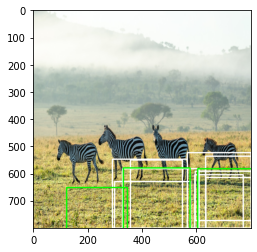

In [52]:
# display RoI samples with positive

img_clone = np.copy(img)

for i in range(pos_roi_per_this_image):
  x1, y1, x2, y2 = roi[pos_index[i]].astype(int)
  cv2.rectangle(img_clone, (x1, y1), (x2, y2), color=(255,255,255),
                thickness=3)
  
for i in range(len(bbox)):
  cv2.rectangle(img_clone, (bbox[i][0], bbox[i][1]), (bbox[i][2], bbox[i][3]), 
                color = (0, 255, 0), thickness=3)

plt.imshow(img_clone)
plt.show()

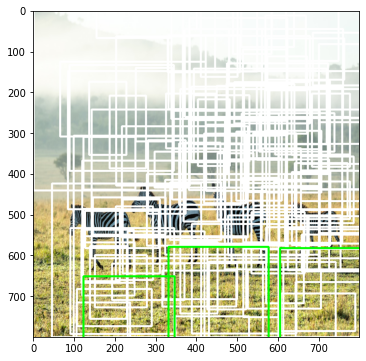

In [53]:
# display RoI samples with negative

img_clone = np.copy(img)

plt.figure(figsize=(9, 6))

for i in range(neg_roi_per_this_image):
  x1, y1, x2, y2 = roi[neg_index[i]].astype(int)
  cv2.rectangle(img_clone, (x1, y1), (x2, y2), color=(255, 255, 255),
                thickness=3)
  
for i in range(len(bbox)):
  cv2.rectangle(img_clone, (bbox[i][0], bbox[i][1]), (bbox[i][2], bbox[i][3]), 
                color = (0, 255, 0), thickness=3)
  
plt.imshow(img_clone)
plt.show()

### 5) Gather positive/negative samples

In [54]:
# now we gather positive samples index and negative samples index
# their respective labels and region proposals

keep_index = np.append(pos_index, neg_index)
gt_roi_labels = gt_roi_label[keep_index]
gt_roi_labels[pos_roi_per_this_image:] = 0 # negative labels => 0
sample_roi = roi[keep_index]
print(sample_roi.shape)

(128, 4)


In [55]:
# pick the ground truth objects for these sample_roi and
# later parameterized as we have done while assigning locations to anchor boxes

bbox_for_sampled_roi = bbox[gt_assignment[keep_index]]
print(bbox_for_sampled_roi.shape)

(128, 4)


In [56]:
width = sample_roi[:, 2] - sample_roi[:, 0]
height = sample_roi[:, 3] - sample_roi[:, 1]
ctr_x = sample_roi[:, 0] + 0.5 * width
ctr_y = sample_roi[:, 1] + 0.5 * height

base_width = bbox_for_sampled_roi[:, 2] - bbox_for_sampled_roi[:, 0]
base_height = bbox_for_sampled_roi[:, 3] - bbox_for_sampled_roi[:, 1]
base_ctr_x = bbox_for_sampled_roi[:, 0] + 0.5 * base_width
base_ctr_y = bbox_for_sampled_roi[:, 1] + 0.5 * base_height 

In [57]:
# transform anchor boxes

eps = np.finfo(height.dtype).eps
height = np.maximum(height, eps)
width = np.maximum(width, eps)

dx = (base_ctr_x - ctr_x) / width
dy = (base_ctr_y - ctr_y) / height
dw = np.log(base_width / width)
dh = np.log(base_height / height)

gt_roi_locs = np.vstack((dx, dy, dw, dh)).transpose()
print(gt_roi_locs.shape)

(128, 4)


## RoI pooling

### 1) Concatenate labels with bbox coordinates

In [58]:
# Take out the features of 128 ROI samples

rois = torch.from_numpy(sample_roi).float()
roi_indices = 0 * np.ones((len(rois),), dtype=np.int32)
roi_indices = torch.from_numpy(roi_indices).float()
print(rois.shape, roi_indices.shape)

torch.Size([128, 4]) torch.Size([128])


In [59]:
indices_and_rois = torch.cat([roi_indices[:, None], rois], dim=1)
xy_indices_and_rois = indices_and_rois[:, [0, 2, 1, 4, 3]]
indices_and_rois = xy_indices_and_rois.contiguous()
print(xy_indices_and_rois.shape)

torch.Size([128, 5])


### 2) RoI pooling

In [60]:
# 7*7 size의 Feature map으로 통일 (max pooling)
size = (7, 7)
adaptive_max_pool = nn.AdaptiveMaxPool2d(size[0], size[1])

In [61]:
output = []
rois = indices_and_rois.data.float()
rois[:, 1:].mul_(1/16.0) # sub-sampling ratio
rois = rois.long()
num_rois = rois.size(0)

for i in range(num_rois):
  roi = rois[i]
  im_idx = roi[0]
  im = output_map.narrow(0, im_idx, 1)[..., roi[1]:(roi[3]+1), roi[2]:(roi[4]+1)]
  tmp = adaptive_max_pool(im)
  output.append(tmp[0])

output = torch.cat(output, 0)

print(output.size())

torch.Size([128, 512, 7, 7])


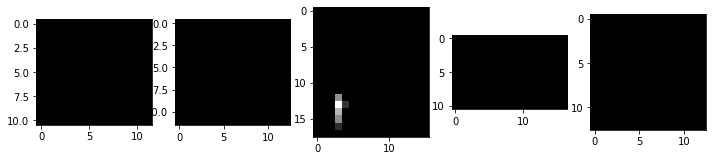

In [62]:
# Visualize the first 5 ROI's feature map (for each feature map, only show the 1st channel of d=512)
fig=plt.figure(figsize=(12, 4))
figNo = 1
for i in range(5):
    roi = rois[i]
    im_idx = roi[0]
    im = output_map.narrow(0, im_idx, 1)[..., roi[2]:(roi[4]+1), roi[1]:(roi[3]+1)]
    tmp = im[0][0].detach().cpu().numpy()
    fig.add_subplot(1, 5, figNo) 
    plt.imshow(tmp, cmap='gray')
    
    figNo +=1
plt.show()

In [63]:
# Reshape the tensor so that we can pass it through the feed forward layer.
k = output.view(output.size(0), -1)
print(k.shape) # 25088 = 7*7*512

torch.Size([128, 25088])


## Fast R-CNN

### 1) Classifier and Bounding box regressor

### 과제 4 :  Fast R-CNN classifier 계산

In [64]:
# 128개의 anchor boxes + (7x7x512) 사이즈의 ROI feature map이 detection network로 보내짐
# predict the objects bounding box and clas of the input image

#####################################################
## ROI pooling 이후 최종 bbox regression 및 classification을 위해 FC layer의 구성을 물어보는 문제입니다.
## 힌트: VGG의 Dense layer의 차원은 무엇이었을까요? 
#####################################################

roi_head_classifier = nn.Sequential(*[nn.Linear(25088 , 4096), nn.Linear(4096, 4096)]).to(DEVICE) #7*7*512 = 25088

#각 class 별로 bounding box coefficients를 예측하는 Bounding box regressor와 class score를 예측하는 Classifier를 정의
#주의! 모든 클래스(4개)가 아니라 각 class임 (cross entropy 계산할때 정답 클래스에 대해서만 계산하기 때문)

#Bounding box regressor
cls_loc = nn.Linear(4096, 2*4).to(DEVICE) #ground truth 좌표값이랑 예측된 bounding box 좌표값
cls_loc.weight.data.normal_(0, 0.01)
cls_loc.bias.data.zero_()

#Classifier
score = nn.Linear(4096, 2).to(DEVICE) 

In [65]:
# passing the output of roi pooling to RoI head

k = roi_head_classifier(k.to(DEVICE))
roi_cls_loc = cls_loc(k)
roi_cls_score = score(k)

print(roi_cls_loc.shape, roi_cls_score.shape)

torch.Size([128, 8]) torch.Size([128, 2])


In [66]:
# Calculate the loss of Fast RCNN based on the gt bboxes and features (h, w, d=512) 
# corresponding to these 128 ROIs

# predicted
print(roi_cls_loc.shape)
print(roi_cls_score.shape)

#actual
print(gt_roi_locs.shape)
print(gt_roi_labels.shape)

torch.Size([128, 8])
torch.Size([128, 2])
(128, 4)
(128,)


In [67]:
gt_roi_labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

### 2) Classification loss

In [68]:
# Converting ground truth to torch variable
gt_roi_loc = torch.from_numpy(gt_roi_locs)
gt_roi_label = torch.from_numpy(np.float32(gt_roi_labels)).long()
print(gt_roi_loc.shape, gt_roi_label.shape)

#Classification loss
roi_cls_loss = F.cross_entropy(roi_cls_score.cpu(), gt_roi_label.cpu(), ignore_index=-1)

torch.Size([128, 4]) torch.Size([128])


### 3) Regression loss

In [69]:
# regression loss

n_sample = roi_cls_loc.shape[0]
roi_loc = roi_cls_loc.view(n_sample, -1, 4)
print(roi_loc.shape)

torch.Size([128, 2, 4])


In [70]:
roi_loc = roi_loc[torch.arange(0, n_sample).long(), gt_roi_label]
print(roi_loc.shape)

torch.Size([128, 4])


In [71]:
# for regression we use smooth l1 loss as defined in the Fast R-CNN paper
pos = gt_roi_label > 0
mask = pos.unsqueeze(1).expand_as(roi_loc)
print(mask.shape)

torch.Size([128, 4])


In [72]:
# take those bounding boxes which have positive labels
mask_loc_preds = roi_loc[mask].view(-1, 4)
mask_loc_targets = gt_roi_loc[mask].view(-1, 4)
print(mask_loc_preds.shape, mask_loc_targets.shape)

x = torch.abs(mask_loc_targets.cpu() - mask_loc_preds.cpu())
roi_loc_loss = ((x < 1).float() * 0.5 * x ** 2) + ((x >= 1).float() * (x - 0.5))
print(roi_loc_loss.sum())

torch.Size([9, 4]) torch.Size([9, 4])
tensor(1.1165, dtype=torch.float64, grad_fn=<SumBackward0>)


### 4) Multi-task loss

In [75]:
roi_lambda = 10.
roi_loss = roi_lambda * roi_loc_loss
print(roi_loss)

total_loss = roi_cls_loss + roi_loss
print(total_loss)

tensor([[9.7562e-02, 2.3296e-02, 4.4606e-01, 1.3046e+00],
        [5.4471e-02, 2.5555e-02, 3.5565e-01, 1.0530e+00],
        [6.0724e-03, 1.1490e-01, 6.7899e-06, 3.0778e-02],
        [1.9518e-01, 4.7720e-04, 3.8496e-01, 3.3676e-01],
        [5.2558e-05, 1.0416e-01, 1.4244e-01, 1.9339e+00],
        [4.2624e-04, 9.7863e-04, 1.1329e-01, 1.6975e+00],
        [2.6936e-02, 2.2594e-02, 1.1816e-01, 9.6769e-01],
        [3.7409e-02, 2.5578e-01, 1.1111e-01, 1.4740e-01],
        [7.0420e-02, 2.2475e-02, 7.8478e-01, 1.7823e-01]], dtype=torch.float64,
       grad_fn=<MulBackward0>)
tensor([[0.7843, 0.7100, 1.1327, 1.9913],
        [0.7412, 0.7122, 1.0423, 1.7397],
        [0.6928, 0.8016, 0.6867, 0.7175],
        [0.8819, 0.6872, 1.0716, 1.0235],
        [0.6867, 0.7909, 0.8291, 2.6206],
        [0.6871, 0.6877, 0.8000, 2.3842],
        [0.7136, 0.7093, 0.8048, 1.6544],
        [0.7241, 0.9425, 0.7978, 0.8341],
        [0.7571, 0.7092, 1.4715, 0.8649]], dtype=torch.float64,
       grad_fn=<AddBackwa